Main changes:
I included the ratings category all the way through because I wanted to compare the ratings and sentiment at the end

In [8]:
import string
import json
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import pickle

# FastText
import fasttext

In [9]:
# Replicated data:
df = pd.read_csv('datasets_39657_61725_amazon_alexa.tsv', delimiter='\t')
# RR data:
#df = pd.read_excel("CSAT Text V2 from Jan 2019 to April 2020.xlsx", sheet_name="raw data")

In [10]:
df.shape

(3150, 5)

In [11]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


# Removing unwanted columns

In [12]:
#generating a random non-repeated ID number to replicate the employee ID numbers
# LEAVING IN THE RATING COLUMN TO CHECK ACCURACY LATER. This means I had to change a few indexers within Mohammad's code
import random
df['id']= random.sample(range(1000000000), len(df))

df = df[['id','rating','date','verified_reviews']]
df

,id,rating,date,verified_reviews
0,240771982,5,31-Jul-18,Love my Echo!
1,780103980,5,31-Jul-18,Loved it!
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer..."
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...
4,219494309,5,31-Jul-18,Music
...,...,...,...,...
3145,300293813,5,30-Jul-18,"Perfect for kids, adults and everyone in betwe..."
3146,415047066,5,30-Jul-18,"Listening to music, searching locations, check..."
3147,731735791,5,30-Jul-18,"I do love these things, i have them running my..."
3148,4034297,5,30-Jul-18,Only complaint I have is that the sound qualit...


In [13]:
df.columns = ['id', 'rating','date', 'text']

In [14]:
df.head()

,id,rating,date,text
0,240771982,5,31-Jul-18,Love my Echo!
1,780103980,5,31-Jul-18,Loved it!
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer..."
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...
4,219494309,5,31-Jul-18,Music


In [15]:
df.shape
# his had (4050, 3), mine has (3150, 4)

(3150, 4)

In [16]:
# Removing rows with null values
df = df[df['text'].notnull()]

In [17]:
df.head()

,id,rating,date,text
0,240771982,5,31-Jul-18,Love my Echo!
1,780103980,5,31-Jul-18,Loved it!
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer..."
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...
4,219494309,5,31-Jul-18,Music


In [18]:
df.shape

(3150, 4)

In [19]:
df.iloc[3,3]

'I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.'

In [20]:
txt = df.iloc[3,3]

In [21]:
def cleaningText(text): #Tessa- added lowercase
    # The following regex just strips of an URL (not just http), any punctuations, 
    # User Names or Any non alphanumeric characters.    
    preprocesstext1 = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)"," ",text).split()).strip().lower()
    
    #start replaceTwoOrMore
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    preprocesstext2 = pattern.sub(r"\1\1", preprocesstext1)    
    return preprocesstext2

In [22]:
df['clean_text'] = df.text.map(cleaningText)

In [23]:
df.head()

,id,rating,date,text,clean_text
0,240771982,5,31-Jul-18,Love my Echo!,love my echo
1,780103980,5,31-Jul-18,Loved it!,loved it
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...
4,219494309,5,31-Jul-18,Music,music


In [24]:
df.iloc[3,4]

'i have had a lot of fun with this thing my yr old learns about dinosaurs i control the lights and play games like categories has nice sound when playing music as well'

### Using language detection model from fatsttext

@article{joulin2016bag,
  title={Bag of Tricks for Efficient Text Classification},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1607.01759},
  year={2016}
}

@article{joulin2016fasttext,
  title={FastText.zip: Compressing text classification models},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Douze, Matthijs and J{\'e}gou, H{\'e}rve and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1612.03651},
  year={2016}
}

In [25]:
lid_model = fasttext.load_model("lid.176.ftz")

In [26]:
#lid_model = fasttext.load_model("lid.176.bin")

In [27]:
def detect_language(text):
    return lid_model.predict(text)[0][0].split('_')[4]

In [28]:
df['language'] = df.clean_text.map(detect_language)
df.clean_text.map(detect_language)

0       en
1       en
2       en
3       en
4       en
        ..
3145    en
3146    en
3147    en
3148    en
3149    en
Name: clean_text, Length: 3150, dtype: object

In [29]:
df.head()

,id,rating,date,text,clean_text,language
0,240771982,5,31-Jul-18,Love my Echo!,love my echo,en
1,780103980,5,31-Jul-18,Loved it!,loved it,en
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en
4,219494309,5,31-Jul-18,Music,music,en


In [30]:
df.language.unique()

array(['en', 'es', 'bs', 'fr', 'de', 'it', 'lv'], dtype=object)

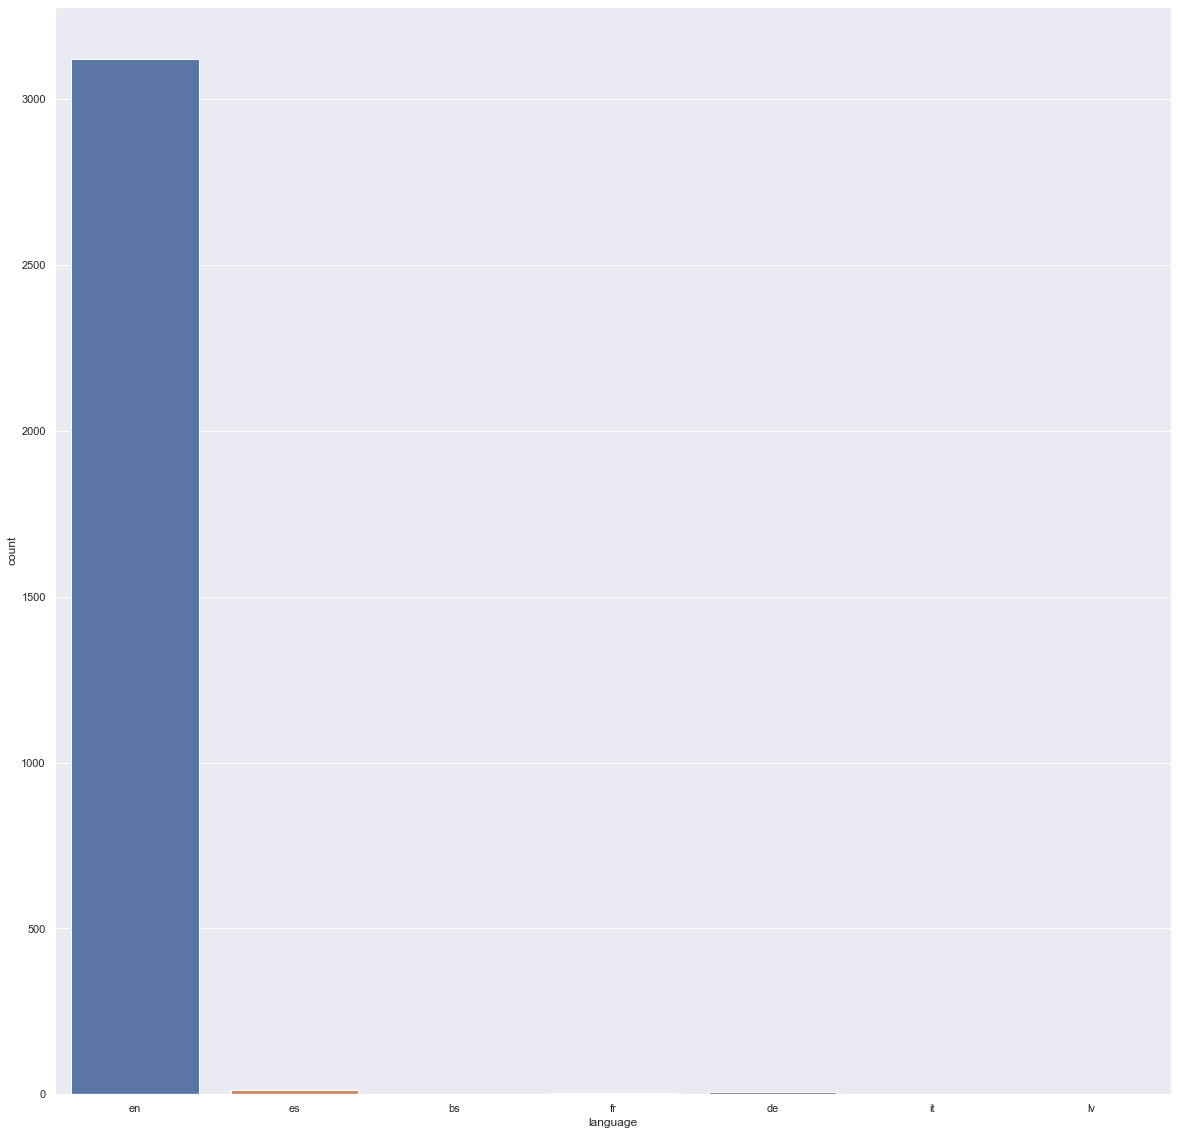

In [31]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="language", data=df)

## Class Imbalance
Majority of texts are in english language so we will focus only on those texts for now

In [32]:
df = df[df.language == 'en']

In [33]:
df.shape
# 3411 is what he has, 3121 with the data I have. 

(3121, 6)

### A bit more data cleaning ...

In [34]:
# Module-level global variables for the `tokenize` function below
PUNCTUATION = set(string.punctuation)
STOPWORDS = list(stopwords.words('english'))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

In [35]:
def tokenize(text):    
    tokens = word_tokenize(text)
    # print (tokens)
#     lowercased = [t.lower() for t in tokens]
    no_punctuation = []
    for word in tokens:
        punct_removed = ''.join([letter for letter in word if not letter in PUNCTUATION])
        no_punctuation.append(punct_removed)
    no_stopwords = [w.strip() for w in no_punctuation if not w in STOPWORDS]
    lemmatized = [LEMMATIZER.lemmatize(w) for w in no_stopwords]
    return [w for w in lemmatized if len(w) > 2]

In [36]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [37]:
df['tokens'] = df.clean_text.map(tokenize)

In [38]:
df.head()

,id,rating,date,text,clean_text,language,tokens
0,240771982,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]"
1,780103980,5,31-Jul-18,Loved it!,loved it,en,[loved]
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c..."
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr..."
4,219494309,5,31-Jul-18,Music,music,en,[music]


## Let's import other NLP libraries for further processing

In [39]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

## Get bigrams and trigrams

In [40]:
def get_bigrams(tokens):
    return list(nltk.bigrams(tokens))

In [41]:
def get_trigrams(tokens):
    return list(nltk.trigrams(tokens))

In [43]:
df

,id,rating,date,text,clean_text,language,tokens
0,240771982,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]"
1,780103980,5,31-Jul-18,Loved it!,loved it,en,[loved]
2,814688673,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c..."
3,118603477,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr..."
4,219494309,5,31-Jul-18,Music,music,en,[music]
...,...,...,...,...,...,...,...
3145,300293813,5,30-Jul-18,"Perfect for kids, adults and everyone in betwe...",perfect for kids adults and everyone in between,en,"[perfect, kid, adult, everyone]"
3146,415047066,5,30-Jul-18,"Listening to music, searching locations, check...",listening to music searching locations checkin...,en,"[listening, music, searching, location, checki..."
3147,731735791,5,30-Jul-18,"I do love these things, i have them running my...",i do love these things i have them running my ...,en,"[love, thing, running, entire, home, light, th..."
3148,4034297,5,30-Jul-18,Only complaint I have is that the sound qualit...,only complaint i have is that the sound qualit...,en,"[complaint, sound, quality, great, mostly, use..."


In [44]:
df['bigrams'] = df.tokens.map(get_bigrams)

RuntimeError: generator raised StopIteration

In [313]:
df['trigrams'] = df.tokens.map(get_trigrams)

In [314]:
df.head()

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams
0,235668992,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]","[(love, echo)]",[]
1,721034420,5,31-Jul-18,Loved it!,loved it,en,[loved],[],[]
2,500819853,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c...","[(sometimes, playing), (playing, game), (game,...","[(sometimes, playing, game), (playing, game, a..."
3,438953068,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr...","[(lot, fun), (fun, thing), (thing, old), (old,...","[(lot, fun, thing), (fun, thing, old), (thing,..."
4,412121922,5,31-Jul-18,Music,music,en,[music],[],[]


In [315]:
bigrams_list = [x for x in df.iloc[:,7]] #changed index from 6 to 7 because new column was included

In [316]:
bigrams_list = [item for sublist in bigrams_list for item in sublist]

In [317]:
bigrams_list[:10]

[('love', 'echo'),
 ('sometimes', 'playing'),
 ('playing', 'game'),
 ('game', 'answer'),
 ('answer', 'question'),
 ('question', 'correctly'),
 ('correctly', 'alexa'),
 ('alexa', 'say'),
 ('say', 'got'),
 ('got', 'wrong')]

In [318]:
trigrams_list = [x for x in df.iloc[:,8]] #changed index from 7 to 8 because new column was included
trigrams_list = [item for sublist in trigrams_list for item in sublist]
trigrams_list[:10]

[('sometimes', 'playing', 'game'),
 ('playing', 'game', 'answer'),
 ('game', 'answer', 'question'),
 ('answer', 'question', 'correctly'),
 ('question', 'correctly', 'alexa'),
 ('correctly', 'alexa', 'say'),
 ('alexa', 'say', 'got'),
 ('say', 'got', 'wrong'),
 ('got', 'wrong', 'answer'),
 ('wrong', 'answer', 'like')]

In [319]:
from collections import Counter

In [320]:
bigrams_freq = Counter(bigrams_list)

In [321]:
bigrams_freq.most_common(10)

[(('echo', 'dot'), 200),
 (('work', 'great'), 154),
 (('easy', 'set'), 134),
 (('love', 'echo'), 115),
 (('play', 'music'), 96),
 (('sound', 'quality'), 96),
 (('prime', 'day'), 92),
 (('great', 'product'), 84),
 (('easy', 'use'), 82),
 (('echo', 'plus'), 82)]

In [322]:
trigrams_freq = Counter(trigrams_list)
trigrams_freq.most_common(10)

[(('love', 'echo', 'dot'), 23),
 (('easy', 'set', 'use'), 20),
 (('love', 'echo', 'show'), 19),
 (('still', 'learning', 'use'), 15),
 (('love', 'love', 'love'), 14),
 (('love', 'fire', 'stick'), 14),
 (('great', 'sound', 'quality'), 13),
 (('love', 'echo', 'spot'), 13),
 (('alexa', 'turn', 'light'), 11),
 (('sound', 'quality', 'great'), 11)]

In [45]:
list_tokens = list(df['tokens'])

In [46]:
list_tokens = [item for sublist in list_tokens for item in sublist]
list_tokens[:10]

['love',
 'echo',
 'loved',
 'sometimes',
 'playing',
 'game',
 'answer',
 'question',
 'correctly',
 'alexa']

In [48]:
tokens_freq = Counter(list_tokens)
tokens_freq.most_common(10)

NameError: name 'Counter' is not defined

In [49]:
tokens_freq_d = {str(k): v for k, v in tokens_freq.items()}

NameError: name 'tokens_freq' is not defined

### Library for generating word cloud

In [327]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

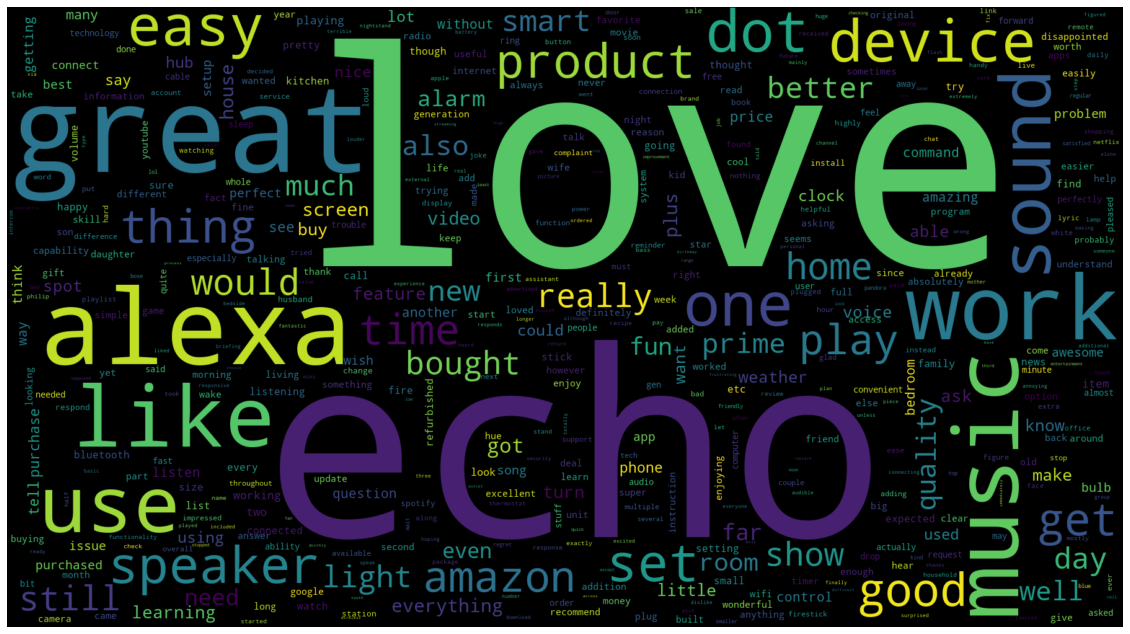

In [328]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=500,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(tokens_freq_d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Unigrams are not making a lot of sense but some of the key words in the corpus are - Response, Issue, Question, Case etc.

In [329]:
bigrams_freq_d  = {'_'.join(k): v for k, v in bigrams_freq.items()}

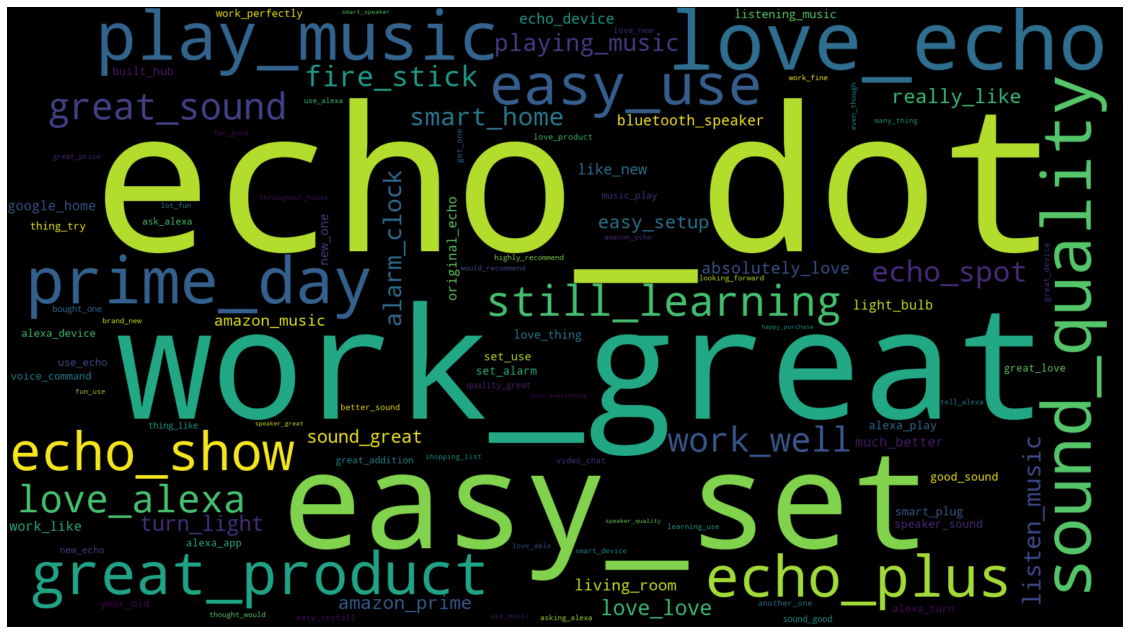

In [330]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=100,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(bigrams_freq_d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [331]:
trigrams_freq_d  = {'_'.join(k): v for k, v in trigrams_freq.items()}

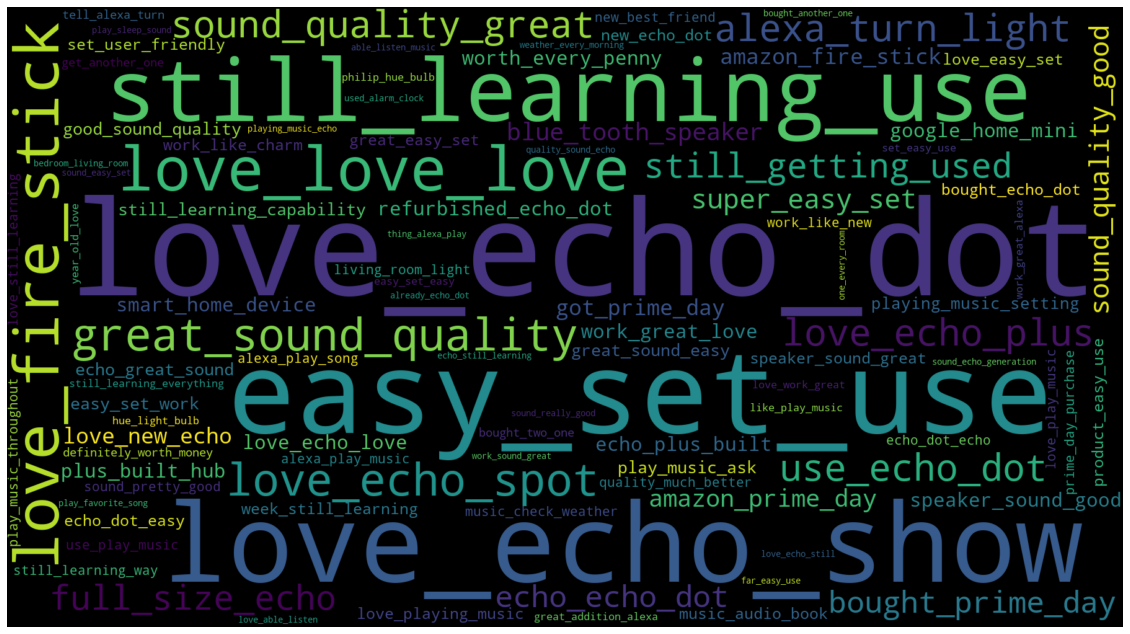

In [332]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1800,height=1000, background_color="black", 
                      max_words=100,relative_scaling=1, 
                      normalize_plurals=False).generate_from_frequencies(trigrams_freq_d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## `case_closed_without` is the key trigram in the corpus which users are talking about. These texts probably will be of negative sentiments. We will explore that in later section

# Running Topic Model using LDA

In [50]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [51]:
# Convert text data to list
data = df.clean_text.values.tolist()
data

['love my echo',
 'loved it',
 'sometimes while playing a game you can answer a question correctly but alexa says you got it wrong and answers the same as you i like being able to turn lights on and off while away from home',
 'i have had a lot of fun with this thing my yr old learns about dinosaurs i control the lights and play games like categories has nice sound when playing music as well',
 'music',
 'i received the echo as a gift i needed another bluetooth or something to play music easily accessible and found this smart speaker can t wait to see what else it can do',
 'without having a cellphone i cannot use many of her features i have an ipad but do not see that of any use it is a great alarm if u r almost deaf you can hear her alarm in the bedroom from out in the living room so that is reason enough to keep her it is fun to ask random questions to hear her response she does not seem to be very smartbon politics yet',
 'i think this is the th one i ve purchased i m working on ge

In [52]:
len(data)

3121

In [53]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
data

['love my echo',
 'loved it',
 'sometimes while playing a game you can answer a question correctly but alexa says you got it wrong and answers the same as you i like being able to turn lights on and off while away from home',
 'i have had a lot of fun with this thing my yr old learns about dinosaurs i control the lights and play games like categories has nice sound when playing music as well',
 'music',
 'i received the echo as a gift i needed another bluetooth or something to play music easily accessible and found this smart speaker can t wait to see what else it can do',
 'without having a cellphone i cannot use many of her features i have an ipad but do not see that of any use it is a great alarm if u r almost deaf you can hear her alarm in the bedroom from out in the living room so that is reason enough to keep her it is fun to ask random questions to hear her response she does not seem to be very smartbon politics yet',
 'i think this is the th one i ve purchased i m working on ge

In [54]:
print(data[:1])

['love my echo']


In [55]:
# is this pre-processing for a second time? sent to "data_words" variable
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['love', 'my', 'echo']]


In [56]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [57]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [58]:
#applying the lemmatization function
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [59]:
print(data_lemmatized[:1])

[['love', 'echo']]


In [60]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)
# this tells us the number of tokens in the dictionary
print(id2word.token2id)
# this shows the word to unique integer mapping

Dictionary(2743 unique tokens: ['echo', 'love', 'able', 'answer', 'away']...)
{'echo': 0, 'love': 1, 'able': 2, 'answer': 3, 'away': 4, 'can': 5, 'correctly': 6, 'game': 7, 'get': 8, 'home': 9, 'light': 10, 'like': 11, 'on': 12, 'play': 13, 'question': 14, 'same': 15, 'say': 16, 'sometimes': 17, 'turn': 18, 'wrong': 19, 'as': 20, 'category': 21, 'control': 22, 'dinosaur': 23, 'fun': 24, 'have': 25, 'learn': 26, 'lot': 27, 'music': 28, 'nice': 29, 'old': 30, 'sound': 31, 'thing': 32, 'well': 33, 'when': 34, 'yr': 35, 'accessible': 36, 'bluetooth': 37, 'easily': 38, 'else': 39, 'find': 40, 'gift': 41, 'need': 42, 'receive': 43, 'see': 44, 'smart': 45, 'speaker': 46, 'wait': 47, 'alarm': 48, 'almost': 49, 'ask': 50, 'bedroom': 51, 'cellphone': 52, 'deaf': 53, 'enough': 54, 'feature': 55, 'great': 56, 'hear': 57, 'ipad': 58, 'keep': 59, 'living': 60, 'many': 61, 'out': 62, 'politic': 63, 'random': 64, 'reason': 65, 'response': 66, 'room': 67, 'seem': 68, 'smartbon': 69, 'use': 70, 'very': 

in Gensim, the corpus contains the word id and its frequency in every document. We can create a BoW corpus from a simple list of documents and from text files. What we need to do is, to pass the tokenised list of words to the object named Dictionary.doc2bow()

In [344]:
# Create Corpus https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
#The function doc2bow() simply counts the number of occurrences of each distinct word,
# converts the word to its integer word id and returns the result as a sparse vector.

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


https://www.tutorialspoint.com/gensim/gensim_creating_a_dictionary.htm

Token − A token means a ‘word’.

Document − A document refers to a sentence or paragraph.

Corpus − It refers to a collection of documents as a bag of words (BoW). a corpus always contains each word’s token’s id along with its frequency count in the document. 

dictionary= tokens mapped to a specific integer

In [345]:
id2word[1]

'love'

In [346]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('echo', 1), ('love', 1)]]

In [347]:
# Build LDA model with 4 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [348]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.055*"set" + 0.044*"play" + 0.034*"more" + 0.033*"time" + 0.024*"music" + 0.022*"ask" + 0.020*"when" + 0.017*"add" + 0.016*"weather" + 0.012*"question"'), (1, '0.063*"echo" + 0.056*"dot" + 0.026*"buy" + 0.018*"want" + 0.015*"think" + 0.014*"also" + 0.014*"need" + 0.013*"day" + 0.013*"prime" + 0.013*"now"'), (2, '0.029*"tv" + 0.024*"tell" + 0.017*"nice" + 0.016*"computer" + 0.016*"as" + 0.015*"awesome" + 0.015*"option" + 0.014*"name" + 0.013*"simple" + 0.013*"issue"'), (3, '0.057*"love" + 0.041*"use" + 0.040*"great" + 0.032*"work" + 0.029*"can" + 0.025*"easy" + 0.024*"music" + 0.023*"so" + 0.021*"device" + 0.020*"speaker"')]


In [352]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.384775  0.044496       1        1  47.130157
1      0.044628 -0.331956       2        1  21.699699
0      0.096360  0.198525       3        1  11.192550
2      0.102714 -0.006762       4        1  10.046416
4      0.141073  0.095698       5        1   9.931168, topic_info=         Term         Freq        Total Category  logprob  loglift
0        echo   628.000000   628.000000  Default  30.0000  30.0000
125       set   410.000000   410.000000  Default  29.0000  29.0000
1        love  1070.000000  1070.000000  Default  28.0000  28.0000
46    speaker   360.000000   360.000000  Default  27.0000  27.0000
383       dot   490.000000   490.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
162    volume    44.230644    46.949867   Topic5  -4.4939   2.2498
2739    adult    26.086054    27.388323   Topic5  -5.0219   2.2608
2742      isn    25.856441    27.406866   Topic5  -5.0307   2.2513
61       many    31.738579    84.867676   Topic5  -4.8258   1.3259
33       well    35.240997   272.253723   Topic5  -4.7211   0.2650

[209 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
315       5  0.961084  actually
191       3  0.990344       add
2739      5  0.949310     adult
48        1  0.991278     alarm
126       1  0.998660     alexa
...     ...       ...       ...
281       5  0.978484      wish
81        1  0.998529      work
635       2  0.992570     worth
296       1  0.993836     would
93        2  0.983679      year

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

In [350]:
for topic in lda_model.print_topics():
    print(topic)
    print("\n")

(0, '0.055*"set" + 0.044*"play" + 0.034*"more" + 0.033*"time" + 0.024*"music" + 0.022*"ask" + 0.020*"when" + 0.017*"add" + 0.016*"weather" + 0.012*"question"')


(1, '0.063*"echo" + 0.056*"dot" + 0.026*"buy" + 0.018*"want" + 0.015*"think" + 0.014*"also" + 0.014*"need" + 0.013*"day" + 0.013*"prime" + 0.013*"now"')


(2, '0.029*"tv" + 0.024*"tell" + 0.017*"nice" + 0.016*"computer" + 0.016*"as" + 0.015*"awesome" + 0.015*"option" + 0.014*"name" + 0.013*"simple" + 0.013*"issue"')


(3, '0.057*"love" + 0.041*"use" + 0.040*"great" + 0.032*"work" + 0.029*"can" + 0.025*"easy" + 0.024*"music" + 0.023*"so" + 0.021*"device" + 0.020*"speaker"')




In [351]:
# Build LDA model with 5 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [353]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.384775  0.044496       1        1  47.130157
1      0.044628 -0.331956       2        1  21.699718
0      0.096360  0.198525       3        1  11.192538
2      0.102714 -0.006762       4        1  10.046418
4      0.141073  0.095698       5        1   9.931168, topic_info=         Term         Freq        Total Category  logprob  loglift
0        echo   628.000000   628.000000  Default  30.0000  30.0000
125       set   410.000000   410.000000  Default  29.0000  29.0000
1        love  1070.000000  1070.000000  Default  28.0000  28.0000
46    speaker   360.000000   360.000000  Default  27.0000  27.0000
383       dot   490.000000   490.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
162    volume    44.230644    46.949867   Topic5  -4.4939   2.2498
2739    adult    26.086054    27.388323   Topic5  -5.0219   2.2608
2742      isn    25.856441    27.406866   Topic5  -5.0307   2.2513
61       many    31.738579    84.867630   Topic5  -4.8258   1.3259
33       well    35.240997   272.253723   Topic5  -4.7211   0.2650

[209 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
315       5  0.961084  actually
191       3  0.990345       add
2739      5  0.949310     adult
48        1  0.991278     alarm
126       1  0.998660     alexa
...     ...       ...       ...
281       5  0.978484      wish
81        1  0.998529      work
635       2  0.992569     worth
296       1  0.993836     would
93        2  0.983678      year

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

In [354]:
# why does this not show 5 topics?
for topic in lda_model.print_topics():
    print(topic)
    print("\n")

(0, '0.092*"set" + 0.036*"ask" + 0.028*"add" + 0.020*"question" + 0.020*"app" + 0.018*"sure" + 0.016*"computer" + 0.015*"friend" + 0.015*"like" + 0.014*"re"')


(1, '0.073*"echo" + 0.057*"dot" + 0.026*"buy" + 0.019*"also" + 0.018*"need" + 0.018*"want" + 0.017*"purchase" + 0.014*"day" + 0.013*"tell" + 0.013*"now"')


(2, '0.032*"tv" + 0.031*"command" + 0.022*"nice" + 0.020*"as" + 0.019*"option" + 0.017*"simple" + 0.015*"stick" + 0.015*"fire" + 0.014*"definitely" + 0.014*"song"')


(3, '0.057*"love" + 0.041*"use" + 0.040*"great" + 0.035*"music" + 0.032*"work" + 0.030*"can" + 0.025*"easy" + 0.023*"so" + 0.022*"device" + 0.020*"play"')


(4, '0.084*"speaker" + 0.079*"sound" + 0.043*"quality" + 0.021*"show" + 0.019*"perfect" + 0.017*"expect" + 0.016*"hub" + 0.016*"wish" + 0.015*"help" + 0.015*"issue"')




## Sentiment Analysis

In [355]:
df.head()

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams
0,235668992,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]","[(love, echo)]",[]
1,721034420,5,31-Jul-18,Loved it!,loved it,en,[loved],[],[]
2,500819853,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c...","[(sometimes, playing), (playing, game), (game,...","[(sometimes, playing, game), (playing, game, a..."
3,438953068,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr...","[(lot, fun), (fun, thing), (thing, old), (old,...","[(lot, fun, thing), (fun, thing, old), (thing,..."
4,412121922,5,31-Jul-18,Music,music,en,[music],[],[]


In [356]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = analyser.polarity_scores(text)
    return score

In [357]:
df['sentiment_score'] = df.text.map(get_sentiment)

In [358]:
def get_negative_score(score):
    return score['neg']

In [359]:
def get_positive_score(score):
    return score['pos']

In [360]:
df['negative_score'] = df.sentiment_score.map(get_negative_score)

In [361]:
df.head()

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams,sentiment_score,negative_score
0,235668992,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]","[(love, echo)]",[],"{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.000
1,721034420,5,31-Jul-18,Loved it!,loved it,en,[loved],[],[],"{'neg': 0.0, 'neu': 0.193, 'pos': 0.807, 'comp...",0.000
2,500819853,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c...","[(sometimes, playing), (playing, game), (game,...","[(sometimes, playing, game), (playing, game, a...","{'neg': 0.095, 'neu': 0.799, 'pos': 0.106, 'co...",0.095
3,438953068,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr...","[(lot, fun), (fun, thing), (thing, old), (old,...","[(lot, fun, thing), (fun, thing, old), (thing,...","{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'comp...",0.000
4,412121922,5,31-Jul-18,Music,music,en,[music],[],[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000


In [362]:
df['positive_score'] = df.sentiment_score.map(get_positive_score)

In [363]:
df.head()

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams,sentiment_score,negative_score,positive_score
0,235668992,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]","[(love, echo)]",[],"{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.000,0.692
1,721034420,5,31-Jul-18,Loved it!,loved it,en,[loved],[],[],"{'neg': 0.0, 'neu': 0.193, 'pos': 0.807, 'comp...",0.000,0.807
2,500819853,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c...","[(sometimes, playing), (playing, game), (game,...","[(sometimes, playing, game), (playing, game, a...","{'neg': 0.095, 'neu': 0.799, 'pos': 0.106, 'co...",0.095,0.106
3,438953068,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr...","[(lot, fun), (fun, thing), (thing, old), (old,...","[(lot, fun, thing), (fun, thing, old), (thing,...","{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'comp...",0.000,0.347
4,412121922,5,31-Jul-18,Music,music,en,[music],[],[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000


In [366]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [367]:
sid = SentimentIntensityAnalyzer()

In [368]:
sid.polarity_scores('Love my Echo!')

{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696}

In [369]:
def get_compound_score(score):
    return score['compound']

In [370]:
df['compound_score'] = df.sentiment_score.map(get_compound_score)

In [371]:
df.head()

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams,sentiment_score,negative_score,positive_score,compound_score
0,235668992,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]","[(love, echo)]",[],"{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.000,0.692,0.6696
1,721034420,5,31-Jul-18,Loved it!,loved it,en,[loved],[],[],"{'neg': 0.0, 'neu': 0.193, 'pos': 0.807, 'comp...",0.000,0.807,0.6360
2,500819853,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c...","[(sometimes, playing), (playing, game), (game,...","[(sometimes, playing, game), (playing, game, a...","{'neg': 0.095, 'neu': 0.799, 'pos': 0.106, 'co...",0.095,0.106,-0.1280
3,438953068,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr...","[(lot, fun), (fun, thing), (thing, old), (old,...","[(lot, fun, thing), (fun, thing, old), (thing,...","{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'comp...",0.000,0.347,0.9169
4,412121922,5,31-Jul-18,Music,music,en,[music],[],[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000


# Short Text Topic Modeling

### Imports

In [78]:
from gsdmm import MovieGroupProcess

##### These are all helper functions that the writer of the article didn't share. 
##### I recreated the top_words helper function and all the rest are not neccessary because they are for preprocessing which we have already done
#from topic_allocation import top_words, topic_attribution
#from preprocessing import tokenize, export_to_csv
#from visualisation import plot_topic_notebook, save_topic_html


import pickle
import matplotlib as plt
import pandas as pd
import numpy as np
import ast

### Preprocessing

We already have preprocessed data from the LDA analysis. I am using the data_lemmatized df which is the same thing as "docs" in the tutorial

In [79]:
data_lemmatized

[['love', 'echo'],
 ['love'],
 ['sometimes',
  'play',
  'game',
  'can',
  'answer',
  'question',
  'correctly',
  'say',
  'get',
  'wrong',
  'answer',
  'same',
  'like',
  'able',
  'turn',
  'light',
  'on',
  'away',
  'home'],
 ['have',
  'lot',
  'fun',
  'thing',
  'yr',
  'old',
  'learn',
  'dinosaur',
  'control',
  'light',
  'play',
  'game',
  'category',
  'nice',
  'sound',
  'when',
  'play',
  'music',
  'as',
  'well'],
 ['music'],
 ['receive',
  'echo',
  'gift',
  'need',
  'bluetooth',
  'play',
  'music',
  'easily',
  'accessible',
  'find',
  'smart',
  'speaker',
  'can',
  'wait',
  'see',
  'else',
  'can'],
 ['have',
  'cellphone',
  'can',
  'use',
  'many',
  'feature',
  'ipad',
  'see',
  'use',
  'great',
  'alarm',
  'almost',
  'deaf',
  'can',
  'hear',
  'alarm',
  'bedroom',
  'out',
  'living',
  'room',
  'reason',
  'enough',
  'keep',
  'fun',
  'ask',
  'random',
  'question',
  'hear',
  'response',
  'seem',
  'very',
  'smartbon',
  'po

### Training

I was having trouble with the MovieGroupProcess function- even though I installed gsdmm it was saying function not found. Eventually I just copied the actual function in at the bottom of this code since so now I can use it

In [65]:
# Init of the Gibbs Sampling Dirichlet Mixture Model algorithm
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=30)

# Input format for the model : list of strings (list of tokens)
docs = data_lemmatized
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

# Fit the model on the data given the chosen seeds
y = mgp.fit(docs, n_terms)


In stage 0: transferred 2516 clusters with 10 clusters populated
In stage 1: transferred 1744 clusters with 10 clusters populated
In stage 2: transferred 1434 clusters with 10 clusters populated
In stage 3: transferred 1292 clusters with 10 clusters populated
In stage 4: transferred 1160 clusters with 10 clusters populated
In stage 5: transferred 1109 clusters with 10 clusters populated
In stage 6: transferred 1043 clusters with 10 clusters populated
In stage 7: transferred 1045 clusters with 10 clusters populated
In stage 8: transferred 997 clusters with 10 clusters populated
In stage 9: transferred 964 clusters with 10 clusters populated
In stage 10: transferred 967 clusters with 10 clusters populated
In stage 11: transferred 956 clusters with 10 clusters populated
In stage 12: transferred 914 clusters with 10 clusters populated
In stage 13: transferred 983 clusters with 10 clusters populated
In stage 14: transferred 942 clusters with 10 clusters populated
In stage 15: transferred 93

### Save and re-load model (optional)

In [81]:
#Save model
#with open('dumps/trained_models/model_v2.model', "wb") as f:
#    pickle.dump(mgp, f)
#   f.close()

# Load the model used in the post
#filehandler = open('dumps/trained_models/model_v1.model', 'rb')
#mgp = pickle.load(filehandler)

### "Top words" helper function 

In [82]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(" — — — — — — — — — ")

### Display our topics

In [83]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topics :', doc_count)
print('*'*20)

# Topics sorted by document inside
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)


# Show the top 5 words by cluster, it helps to make the topic_dict below
top_words(mgp.cluster_word_distribution, top_index, 5)

Number of documents per topics : [210 259 290 170  92 691 567  96 305 441]
********************
Most important clusters (by number of docs inside): [5 6 9 8 2 1 0 3 7 4]
********************
Cluster 5 : [('love', 225), ('great', 206), ('work', 184), ('echo', 178), ('sound', 118)]
 — — — — — — — — — 
Cluster 6 : [('love', 214), ('great', 171), ('easy', 153), ('use', 143), ('set', 97)]
 — — — — — — — — — 
Cluster 9 : [('echo', 260), ('work', 157), ('can', 151), ('device', 140), ('use', 136)]
 — — — — — — — — — 
Cluster 8 : [('love', 101), ('use', 98), ('so', 91), ('easy', 77), ('very', 75)]
 — — — — — — — — — 
Cluster 2 : [('music', 86), ('love', 82), ('echo', 77), ('can', 70), ('great', 67)]
 — — — — — — — — — 
Cluster 1 : [('music', 120), ('love', 95), ('great', 80), ('use', 77), ('can', 75)]
 — — — — — — — — — 
Cluster 0 : [('love', 111), ('can', 55), ('echo', 49), ('great', 44), ('set', 41)]
 — — — — — — — — — 
Cluster 3 : [('music', 71), ('love', 67), ('use', 64), ('play', 46), ('ge

### This is the academic paper this tutorial is based on: 
http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
### An interesting forum on short text topic modeling:
https://www.researchgate.net/post/What_is_a_good_way_to_perform_topic_modeling_on_short_text

### Visualize the topics

In [87]:
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus)

[[(0, 1), (1, 1)], [(1, 1)], [(2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(7, 1), (10, 1), (13, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(28, 1)], [(0, 1), (5, 2), (13, 1), (28, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(5, 2), (14, 1), (24, 1), (25, 1), (44, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1)], [(8, 1), (10, 1), (13, 1), (22, 1), (28, 1), (55, 1), (67, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1)], [(56, 1), (82, 1)], [(1, 1), (8, 1), (56, 1), (57, 1), (83, 1), (84, 1),

In [89]:
n_terms

2743

In [91]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)
# this tells us the number of tokens in the dictionary
#print(id2word.token2id)
# this shows the word to unique integer mapping

Dictionary(2743 unique tokens: ['echo', 'love', 'able', 'answer', 'away']...)


In [92]:
print(y)

[5, 6, 9, 7, 6, 7, 6, 3, 5, 1, 7, 8, 2, 1, 6, 3, 6, 6, 5, 1, 6, 1, 2, 3, 5, 5, 0, 5, 2, 9, 6, 9, 6, 1, 2, 3, 8, 6, 9, 7, 1, 9, 8, 0, 6, 3, 1, 6, 5, 9, 6, 5, 6, 5, 8, 6, 6, 5, 1, 6, 8, 3, 5, 3, 6, 5, 0, 9, 6, 5, 6, 5, 8, 5, 7, 5, 5, 3, 6, 6, 5, 5, 5, 5, 2, 6, 2, 2, 9, 1, 5, 8, 1, 8, 3, 7, 6, 3, 8, 5, 5, 5, 9, 6, 6, 3, 2, 9, 6, 5, 1, 4, 8, 0, 5, 9, 5, 4, 3, 6, 5, 5, 6, 6, 9, 6, 6, 2, 6, 6, 5, 5, 6, 5, 5, 0, 6, 3, 4, 8, 6, 2, 9, 1, 5, 1, 5, 6, 3, 5, 1, 8, 0, 1, 2, 4, 2, 6, 5, 3, 9, 4, 9, 6, 5, 4, 8, 8, 9, 6, 3, 4, 0, 2, 3, 5, 6, 4, 2, 6, 3, 5, 9, 5, 8, 7, 6, 8, 9, 2, 6, 6, 6, 6, 8, 4, 7, 3, 5, 5, 5, 4, 8, 4, 1, 6, 4, 5, 0, 2, 2, 9, 6, 6, 1, 5, 1, 9, 1, 5, 5, 0, 5, 1, 1, 5, 6, 8, 9, 6, 0, 7, 0, 1, 3, 5, 3, 3, 8, 5, 6, 5, 8, 8, 6, 0, 5, 8, 1, 1, 5, 8, 8, 8, 8, 8, 3, 6, 5, 2, 5, 4, 8, 5, 8, 5, 1, 2, 5, 3, 0, 3, 8, 2, 6, 5, 5, 5, 5, 5, 9, 5, 6, 1, 9, 5, 1, 2, 5, 7, 3, 8, 6, 5, 6, 1, 2, 1, 1, 6, 6, 6, 1, 6, 6, 2, 6, 1, 1, 1, 2, 2, 2, 8, 5, 3, 4, 4, 5, 5, 6, 5, 3, 8, 8, 7, 5, 9, 6, 6, 6, 0, 1, 

In [96]:
mgp.cluster_word_distribution

[{'music': 18,
  'echo': 49,
  'need': 10,
  'play': 23,
  'find': 11,
  'speaker': 6,
  'can': 55,
  'see': 11,
  'think': 3,
  'one': 7,
  'purchase': 10,
  'work': 31,
  'get': 28,
  'room': 9,
  'house': 10,
  'really': 10,
  'feature': 12,
  'echos': 3,
  'control': 4,
  'light': 8,
  'love': 111,
  'how': 11,
  'good': 5,
  'sound': 5,
  'alexa': 39,
  'understand': 3,
  'command': 10,
  'time': 19,
  'song': 6,
  'other': 20,
  'program': 3,
  'great': 44,
  'no': 5,
  'list': 5,
  'amazon': 6,
  'star': 5,
  'reason': 5,
  'easy': 25,
  'set': 41,
  'wonderful': 5,
  'very': 24,
  'cool': 5,
  'product': 31,
  'item': 2,
  'just': 35,
  'add': 6,
  'audible': 2,
  'make': 24,
  'even': 14,
  'quality': 3,
  'expect': 4,
  'stop': 9,
  'voice': 11,
  'phone': 8,
  'call': 14,
  'game': 11,
  'weather': 8,
  'little': 3,
  'enjoy': 9,
  'funny': 5,
  'buy': 28,
  'look': 7,
  'fun': 7,
  'wind': 3,
  'totally': 5,
  'useful': 6,
  'part': 7,
  'home': 20,
  'turn': 19,
  'more': 

In [94]:
# Visualize the topics
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

vis = pyLDAvis.gensim.prepare(mgp, y, dictionary=vocab)


# Plot the cluster in a notebook
#plot_topic_notebook(tokenized_data, docs, mgp)

a

TypeError: type object argument after * must be an iterable, not int

they give us the keywords
then whichever word it is most close to it will add into 


# Comparing vadersentiment scores with labeled data


In [372]:
dfs = df.copy() #dataframe with sentiment -> dfs
dfs

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams,sentiment_score,negative_score,positive_score,compound_score
0,235668992,5,31-Jul-18,Love my Echo!,love my echo,en,"[love, echo]","[(love, echo)]",[],"{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.000,0.692,0.6696
1,721034420,5,31-Jul-18,Loved it!,loved it,en,[loved],[],[],"{'neg': 0.0, 'neu': 0.193, 'pos': 0.807, 'comp...",0.000,0.807,0.6360
2,500819853,4,31-Jul-18,"Sometimes while playing a game, you can answer...",sometimes while playing a game you can answer ...,en,"[sometimes, playing, game, answer, question, c...","[(sometimes, playing), (playing, game), (game,...","[(sometimes, playing, game), (playing, game, a...","{'neg': 0.095, 'neu': 0.799, 'pos': 0.106, 'co...",0.095,0.106,-0.1280
3,438953068,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing my yr ...,en,"[lot, fun, thing, old, learns, dinosaur, contr...","[(lot, fun), (fun, thing), (thing, old), (old,...","[(lot, fun, thing), (fun, thing, old), (thing,...","{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'comp...",0.000,0.347,0.9169
4,412121922,5,31-Jul-18,Music,music,en,[music],[],[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,92535884,5,30-Jul-18,"Perfect for kids, adults and everyone in betwe...",perfect for kids adults and everyone in between,en,"[perfect, kid, adult, everyone]","[(perfect, kid), (kid, adult), (adult, everyone)]","[(perfect, kid, adult), (kid, adult, everyone)]","{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou...",0.000,0.380,0.6467
3146,685204423,5,30-Jul-18,"Listening to music, searching locations, check...",listening to music searching locations checkin...,en,"[listening, music, searching, location, checki...","[(listening, music), (music, searching), (sear...","[(listening, music, searching), (music, search...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000
3147,564005473,5,30-Jul-18,"I do love these things, i have them running my...",i do love these things i have them running my ...,en,"[love, thing, running, entire, home, light, th...","[(love, thing), (thing, running), (running, en...","[(love, thing, running), (thing, running, enti...","{'neg': 0.027, 'neu': 0.746, 'pos': 0.227, 'co...",0.027,0.227,0.9485
3148,696826881,5,30-Jul-18,Only complaint I have is that the sound qualit...,only complaint i have is that the sound qualit...,en,"[complaint, sound, quality, great, mostly, use...","[(complaint, sound), (sound, quality), (qualit...","[(complaint, sound, quality), (sound, quality,...","{'neg': 0.08, 'neu': 0.839, 'pos': 0.08, 'comp...",0.080,0.080,0.0008


In [377]:
# average positive sentiment score by rating
dfs['positive_score'].groupby(dfs['rating']).mean()
# shows a promising correlation

rating
1    0.062510
2    0.096129
3    0.134164
4    0.269770
5    0.371760
Name: positive_score, dtype: float64

In [378]:
# average negative sentiment score by rating
dfs['negative_score'].groupby(dfs['rating']).mean()
# this is less promising, lots of reviews of 1 star are not being identified as negative

rating
1    0.084338
2    0.109333
3    0.057309
4    0.030819
5    0.015420
Name: negative_score, dtype: float64

Analyzing the negative reviews:
This process doesnt seem to do a great job understanding the sentences. Things like "not much features" have "not" removed (should take this out of the stopwords?), leaving with "much" "feature" tokens and then giving a negative score of 0. We need to use BERT to get context for things like this I think. 


In [380]:
dfs[dfs['rating']==1]

,id,rating,date,text,clean_text,language,tokens,bigrams,trigrams,sentiment_score,negative_score,positive_score,compound_score
141,29538317,1,30-Jul-18,Not much features.,not much features,en,"[much, feature]","[(much, feature)]",[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000
162,78853248,1,30-Jul-18,"Stopped working after 2 weeks ,didn't follow c...",stopped working after weeks didn t follow comm...,en,"[stopped, working, week, follow, command, real...","[(stopped, working), (working, week), (week, f...","[(stopped, working, week), (working, week, fol...","{'neg': 0.105, 'neu': 0.661, 'pos': 0.234, 'co...",0.105,0.234,0.5179
341,906511553,1,28-Jul-18,Alexa hardly came on..,alexa hardly came on,en,"[alexa, hardly, came]","[(alexa, hardly), (hardly, came)]","[(alexa, hardly, came)]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000
350,800549639,1,31-Jul-18,Item no longer works after just 5 months of us...,item no longer works after just months of use ...,en,"[item, longer, work, month, use, connect, wifi...","[(item, longer), (longer, work), (work, month)...","[(item, longer, work), (longer, work, month), ...","{'neg': 0.104, 'neu': 0.896, 'pos': 0.0, 'comp...",0.104,0.000,-0.2960
361,183873114,1,29-Jul-18,This thing barely works. You have to select 3r...,this thing barely works you have to select rd ...,en,"[thing, barely, work, select, party, apps, stu...","[(thing, barely), (barely, work), (work, selec...","[(thing, barely, work), (barely, work, select)...","{'neg': 0.081, 'neu': 0.841, 'pos': 0.078, 'co...",0.081,0.078,-0.0258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,435240023,1,30-Jul-18,I was really happy with my original echo so i ...,i was really happy with my original echo so i ...,en,"[really, happy, original, echo, thought, get, ...","[(really, happy), (happy, original), (original...","[(really, happy, original), (happy, original, ...","{'neg': 0.07, 'neu': 0.772, 'pos': 0.157, 'com...",0.070,0.157,0.8979
3047,740814805,1,30-Jul-18,Echo Dot responds to us when we aren't even ta...,echo dot responds to us when we aren t even ta...,en,"[echo, dot, responds, even, talking, unplugged...","[(echo, dot), (dot, responds), (responds, even...","[(echo, dot, responds), (dot, responds, even),...","{'neg': 0.0, 'neu': 0.894, 'pos': 0.106, 'comp...",0.000,0.106,0.3612
3048,75283023,1,30-Jul-18,NOT CONNECTED TO MY PHONE PLAYLIST :(,not connected to my phone playlist,en,"[connected, phone, playlist]","[(connected, phone), (phone, playlist)]","[(connected, phone, playlist)]","{'neg': 0.326, 'neu': 0.674, 'pos': 0.0, 'comp...",0.326,0.000,-0.4404
3091,38503203,1,30-Jul-18,I didn’t order it,i didn t order it,en,[order],[],[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000


# Movie group process 

In [5]:
from numpy.random import multinomial
from numpy import log, exp
from numpy import argmax
import json

class MovieGroupProcess:
    def __init__(self, K=8, alpha=0.1, beta=0.1, n_iters=30):
        '''
        A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to
        describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the
        clustering short text documents.
        Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

        Imagine a professor is leading a film class. At the start of the class, the students
        are randomly assigned to K tables. Before class begins, the students make lists of
        their favorite films. The teacher reads the role n_iters times. When
        a student is called, the student must select a new table satisfying either:
            1) The new table has more students than the current table.
        OR
            2) The new table has students with similar lists of favorite movies.

        :param K: int
            Upper bound on the number of possible clusters. Typically many fewer
        :param alpha: float between 0 and 1
            Alpha controls the probability that a student will join a table that is currently empty
            When alpha is 0, no one will join an empty table.
        :param beta: float between 0 and 1
            Beta controls the student's affinity for other students with similar interests. A low beta means
            that students desire to sit with students of similar interests. A high beta means they are less
            concerned with affinity and are more influenced by the popularity of a table
        :param n_iters:
        '''
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.n_iters = n_iters

        # slots for computed variables
        self.number_docs = None
        self.vocab_size = None
        self.cluster_doc_count = [0 for _ in range(K)]
        self.cluster_word_count = [0 for _ in range(K)]
        self.cluster_word_distribution = [{} for i in range(K)]

    @staticmethod
    def from_data(K, alpha, beta, D, vocab_size, cluster_doc_count, cluster_word_count, cluster_word_distribution):
        '''
        Reconstitute a MovieGroupProcess from previously fit data
        :param K:
        :param alpha:
        :param beta:
        :param D:
        :param vocab_size:
        :param cluster_doc_count:
        :param cluster_word_count:
        :param cluster_word_distribution:
        :return:
        '''
        mgp = MovieGroupProcess(K, alpha, beta, n_iters=30)
        mgp.number_docs = D
        mgp.vocab_size = vocab_size
        mgp.cluster_doc_count = cluster_doc_count
        mgp.cluster_word_count = cluster_word_count
        mgp.cluster_word_distribution = cluster_word_distribution
        return mgp

    @staticmethod
    def _sample(p):
        '''
        Sample with probability vector p from a multinomial distribution
        :param p: list
            List of probabilities representing probability vector for the multinomial distribution
        :return: int
            index of randomly selected output
        '''
        return [i for i, entry in enumerate(multinomial(1, p)) if entry != 0][0]

    def fit(self, docs, vocab_size):
        '''
        Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return: list of length len(doc)
            cluster label for each document
        '''
        alpha, beta, K, n_iters, V = self.alpha, self.beta, self.K, self.n_iters, vocab_size

        D = len(docs)
        self.number_docs = D
        self.vocab_size = vocab_size

        # unpack to easy var names
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution
        cluster_count = K
        d_z = [None for i in range(len(docs))]

        # initialize the clusters
        for i, doc in enumerate(docs):

            # choose a random  initial cluster for the doc
            z = self._sample([1.0 / K for _ in range(K)])
            d_z[i] = z
            m_z[z] += 1
            n_z[z] += len(doc)

            for word in doc:
                if word not in n_z_w[z]:
                    n_z_w[z][word] = 0
                n_z_w[z][word] += 1

        for _iter in range(n_iters):
            total_transfers = 0

            for i, doc in enumerate(docs):

                # remove the doc from it's current cluster
                z_old = d_z[i]

                m_z[z_old] -= 1
                n_z[z_old] -= len(doc)

                for word in doc:
                    n_z_w[z_old][word] -= 1

                    # compact dictionary to save space
                    if n_z_w[z_old][word] == 0:
                        del n_z_w[z_old][word]

                # draw sample from distribution to find new cluster
                p = self.score(doc)
                z_new = self._sample(p)

                # transfer doc to the new cluster
                if z_new != z_old:
                    total_transfers += 1

                d_z[i] = z_new
                m_z[z_new] += 1
                n_z[z_new] += len(doc)

                for word in doc:
                    if word not in n_z_w[z_new]:
                        n_z_w[z_new][word] = 0
                    n_z_w[z_new][word] += 1

            cluster_count_new = sum([1 for v in m_z if v > 0])
            print("In stage %d: transferred %d clusters with %d clusters populated" % (
            _iter, total_transfers, cluster_count_new))
            if total_transfers == 0 and cluster_count_new == cluster_count and _iter>25:
                print("Converged.  Breaking out.")
                break
            cluster_count = cluster_count_new
        self.cluster_word_distribution = n_z_w
        return d_z

    def score(self, doc):
        '''
        Score a document

        Implements formula (3) of Yin and Wang 2014.
        http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

        :param doc: list[str]: The doc token stream
        :return: list[float]: A length K probability vector where each component represents
                              the probability of the document appearing in a particular cluster
        '''
        alpha, beta, K, V, D = self.alpha, self.beta, self.K, self.vocab_size, self.number_docs
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution

        p = [0 for _ in range(K)]

        #  We break the formula into the following pieces
        #  p = N1*N2/(D1*D2) = exp(lN1 - lD1 + lN2 - lD2)
        #  lN1 = log(m_z[z] + alpha)
        #  lN2 = log(D - 1 + K*alpha)
        #  lN2 = log(product(n_z_w[w] + beta)) = sum(log(n_z_w[w] + beta))
        #  lD2 = log(product(n_z[d] + V*beta + i -1)) = sum(log(n_z[d] + V*beta + i -1))

        lD1 = log(D - 1 + K * alpha)
        doc_size = len(doc)
        for label in range(K):
            lN1 = log(m_z[label] + alpha)
            lN2 = 0
            lD2 = 0
            for word in doc:
                lN2 += log(n_z_w[label].get(word, 0) + beta)
            for j in range(1, doc_size +1):
                lD2 += log(n_z[label] + V * beta + j - 1)
            p[label] = exp(lN1 - lD1 + lN2 - lD2)

        # normalize the probability vector
        pnorm = sum(p)
        pnorm = pnorm if pnorm>0 else 1
        return [pp/pnorm for pp in p]

    def choose_best_label(self, doc):
        '''
        Choose the highest probability label for the input document
        :param doc: list[str]: The doc token stream
        :return:
        '''
        p = self.score(doc)
        return argmax(p),max(p)